In [1]:
!pip install tqdm

In [2]:
import os
import random
import argparse
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Configaration

In [3]:
# ───── Special Tokens ─────
PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2

# ───── Config & Utilities ─────

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def parse_args():
    p = argparse.ArgumentParser(description="Seq2Seq with Attention (Reverse Task)")
    p.add_argument('--vocab_size', type=int, default=50, help='number of unique tokens (excl PAD/BOS/EOS)')
    p.add_argument('--seq_len', type=int, default=10)
    p.add_argument('--batch_size', type=int, default=64)
    p.add_argument('--emb_dim', type=int, default=128)
    p.add_argument('--hid_dim', type=int, default=256)
    p.add_argument('--n_layers', type=int, default=1)
    p.add_argument('--lr', type=float, default=1e-3)
    p.add_argument('--epochs', type=int, default=10)
    p.add_argument('--train_samples', type=int, default=10000)
    p.add_argument('--val_samples', type=int, default=1000)
    p.add_argument('--num_workers', type=int, default=2)
    p.add_argument('--clip', type=float, default=1.0)
    p.add_argument('--seed', type=int, default=42)
    p.add_argument('--output_dir', type=str, default='checkpoints')
    args, _ = p.parse_known_args()
    return args

# Data Generation

In [4]:
class ReverseSeqDataset(Dataset):
    def __init__(self, num_samples, seq_len, vocab_size):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        src = torch.randint(3, self.vocab_size, (self.seq_len,), dtype=torch.long)
        trg = torch.empty(self.seq_len + 1, dtype=torch.long)
        trg[0] = BOS_IDX
        trg[1:] = torch.flip(src, dims=[0])
        return src, trg


def collate_fn(batch):
    srcs, trgs = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(srcs, padding_value=PAD_IDX, batch_first=True)
    trg_batch = nn.utils.rnn.pad_sequence(trgs, padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch


def make_dataloader(num_samples, cfg, shuffle=True):
    ds = ReverseSeqDataset(num_samples, cfg.seq_len, cfg.vocab_size)
    return DataLoader(
        ds,
        batch_size=cfg.batch_size,
        shuffle=shuffle,
        num_workers=cfg.num_workers,
        pin_memory=torch.cuda.is_available(),
        collate_fn=collate_fn
    )

# Model Definition

In [5]:

# ───── Model ─────
class Encoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.embedding = nn.Embedding(cfg.vocab_size, cfg.emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(cfg.emb_dim, cfg.hid_dim, cfg.n_layers,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(cfg.hid_dim * 2, cfg.hid_dim)

    def forward(self, src):
        emb = self.embedding(src)
        outputs, hidden = self.rnn(emb)
        h_cat = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = torch.tanh(self.fc(h_cat)).unsqueeze(0)
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = nn.Linear(cfg.hid_dim * 3, cfg.hid_dim)
        self.v = nn.Linear(cfg.hid_dim, 1, bias=False)

    def forward(self, hidden, enc_outputs, mask=None):
        B, S, _ = enc_outputs.size()
        h = hidden.permute(1, 0, 2).repeat(1, S, 1)
        energy = torch.tanh(self.attn(torch.cat((h, enc_outputs), dim=2)))
        scores = self.v(energy).squeeze(2)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        return torch.softmax(scores, dim=1)


class Decoder(nn.Module):
    def __init__(self, cfg, attention):
        super().__init__()
        self.embedding = nn.Embedding(cfg.vocab_size, cfg.emb_dim, padding_idx=PAD_IDX)
        self.attn = attention
        self.rnn = nn.GRU(cfg.emb_dim + cfg.hid_dim * 2, cfg.hid_dim,
                          cfg.n_layers, batch_first=True)
        self.fc_out = nn.Linear(cfg.emb_dim + cfg.hid_dim * 3, cfg.vocab_size)

    def forward(self, input, hidden, enc_outputs):
        emb = self.embedding(input).unsqueeze(1)
        attn_w = self.attn(hidden, enc_outputs).unsqueeze(1)
        weighted = torch.bmm(attn_w, enc_outputs)
        rnn_in = torch.cat((emb, weighted), dim=2)
        out, hidden = self.rnn(rnn_in, hidden)
        out = out.squeeze(1)
        weighted = weighted.squeeze(1)
        emb = emb.squeeze(1)
        pred = self.fc_out(torch.cat((out, weighted, emb), dim=1))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, cfg, device):
        super().__init__()
        self.cfg = cfg
        self.encoder = Encoder(cfg)
        self.attn = Attention(cfg)
        self.decoder = Decoder(cfg, self.attn)
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        B = src.size(0)
        T = trg.size(1) if trg is not None else (self.cfg.seq_len + 1)
        V = self.cfg.vocab_size
        outputs = torch.zeros(B, T, V, device=self.device)
        enc_outputs, hidden = self.encoder(src)
        input = torch.full((B,), BOS_IDX, device=self.device, dtype=torch.long)
        for t in range(1, T):
            pred, hidden = self.decoder(input, hidden, enc_outputs)
            outputs[:, t] = pred
            teacher = trg[:, t] if (trg is not None and random.random() < teacher_forcing_ratio) else pred.argmax(1)
            input = teacher
        return outputs

# Training & Evaluation

In [6]:
# ───── Train & Eval ─────
def train_one_epoch(model, loader, optimizer, criterion, scaler, cfg):
    model.train()
    total_loss = 0.0
    for src, trg in tqdm(loader, desc="Train", leave=False):
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()
        with autocast(model.device.type):
            output = model(src, trg, teacher_forcing_ratio=0.5)
            loss = criterion(output[:, 1:].reshape(-1, output.size(-1)), trg[:, 1:].reshape(-1))
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), cfg.clip)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(model.device), trg.to(model.device)
            preds = model(src, trg, teacher_forcing_ratio=0.0).argmax(dim=2)
            correct += (preds[:, 1:] == trg[:, 1:]).all(dim=1).sum().item()
            total += src.size(0)
    return correct / total

# Main

In [7]:
# ───── Main ─────
if __name__ == '__main__':
    args = parse_args()
    args.vocab_size += 3  # account for PAD, BOS, EOS
    set_seed(args.seed)
    os.makedirs(args.output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_loader = make_dataloader(args.train_samples, args, shuffle=True)
    val_loader = make_dataloader(args.val_samples, args, shuffle=False)

    model = Seq2Seq(args, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    scaler = GradScaler(device.type)

    train_losses, val_accs = [], []
    for epoch in range(1, args.epochs + 1):
        loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, args)
        acc = evaluate(model, val_loader)
        scheduler.step(loss)
        train_losses.append(loss)
        val_accs.append(acc)
        print(f"Epoch {epoch:02d}: loss={loss:.4f}, val_acc={acc:.2%}")
        torch.save(model.state_dict(), Path(args.output_dir) / f"epoch{epoch:02d}.pth")

Using device: cuda


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 01: loss=1.5061, val_acc=88.20%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 02: loss=0.0866, val_acc=87.60%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 03: loss=0.0445, val_acc=98.40%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 04: loss=0.0165, val_acc=99.90%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 05: loss=0.0007, val_acc=99.80%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 06: loss=0.0088, val_acc=86.80%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 07: loss=0.0265, val_acc=99.00%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 08: loss=0.0090, val_acc=100.00%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 09: loss=0.0007, val_acc=100.00%


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: loss=0.0004, val_acc=100.00%


# Visualizing Loss & Accuracy

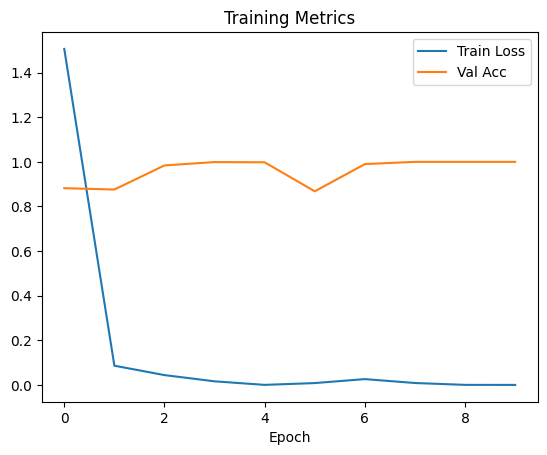

In [8]:
# Plot metrics
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training Metrics')
plt.show()

# Saving & Loading

In [9]:
# Save full model
torch.save(model, 'seq2seq_full_model.pth')
print("Training complete.")

Training complete.
